In [10]:
import torch
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn, optim

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((48, 48)),  # Resize to match FER-2013 dimensions
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load train and test datasets with correct transform usage
train_dataset = datasets.ImageFolder(root=r"D:\train", transform=transform)
test_dataset = datasets.ImageFolder(root=r"D:\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define CNN Model
class CNN_FER(nn.Module):
    def __init__(self):
        super(CNN_FER, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 7)  # FER-2013 has 7 emotion classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten before FC layer
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_FER().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)

    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss / num_batches:.4f}")

# Save Model
torch.save(model.state_dict(), "detection_model.pth")

# Evaluation Loop (On Test Data)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _,predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/30, Loss: 1.6489
Epoch 2/30, Loss: 1.4236
Epoch 3/30, Loss: 1.3002
Epoch 4/30, Loss: 1.2105
Epoch 5/30, Loss: 1.1366
Epoch 6/30, Loss: 1.0629
Epoch 7/30, Loss: 1.0034
Epoch 8/30, Loss: 0.9375
Epoch 9/30, Loss: 0.8748
Epoch 10/30, Loss: 0.8090
Epoch 11/30, Loss: 0.7566
Epoch 12/30, Loss: 0.7036
Epoch 13/30, Loss: 0.6549
Epoch 14/30, Loss: 0.6047
Epoch 15/30, Loss: 0.5612
Epoch 16/30, Loss: 0.5326
Epoch 17/30, Loss: 0.5016
Epoch 18/30, Loss: 0.4772
Epoch 19/30, Loss: 0.4534
Epoch 20/30, Loss: 0.4228
Epoch 21/30, Loss: 0.4168
Epoch 22/30, Loss: 0.3920
Epoch 23/30, Loss: 0.3842
Epoch 24/30, Loss: 0.3633
Epoch 25/30, Loss: 0.3549
Epoch 26/30, Loss: 0.3467
Epoch 27/30, Loss: 0.3360
Epoch 28/30, Loss: 0.3309
Epoch 29/30, Loss: 0.3173
Epoch 30/30, Loss: 0.3029
Test Accuracy: 56.63%


In [11]:
from collections import Counter

print(Counter(train_dataset.targets))
print(Counter(test_dataset.targets))


Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})
Counter({3: 1774, 5: 1247, 4: 1233, 2: 1024, 0: 958, 6: 831, 1: 111})


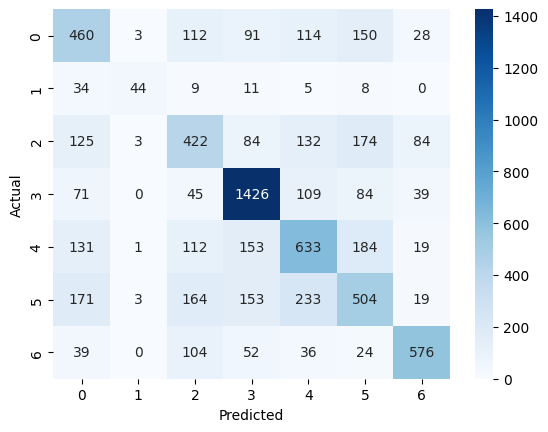

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
from torchvision import models

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(1280, 7)  # 7 emotion classes
model = model.to(device)


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:03<00:00, 3.86MB/s]


In [1]:
# Calculate and print per-class accuracy
class_names = train_dataset.classes
for i, class_name in enumerate(class_names):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Accuracy for class {class_name}: {accuracy:.2f}%")

print(f"Overall Test Accuracy: {100 * correct / total:.2f}%")


NameError: name 'train_dataset' is not defined

In [3]:
import torch
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn, optim

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((48, 48)),  # Resize to match FER-2013 dimensions
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

# Load train and test datasets
train_dataset = datasets.ImageFolder(root=r"D:\train", transform=transform)
test_dataset = datasets.ImageFolder(root=r"D:\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Emotion Detection Model
class EmotionDetectionModel(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectionModel, self).__init__()
        self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        # Modify the classifier to match the number of classes
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionDetectionModel(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss / num_batches:.4f}")

# Save the trained model
torch.save(model.state_dict(), "mobilenet_emotion_model.pth")

# Evaluation Loop (On Test Data)
model.eval()
correct, total = 0, 0
class_correct = [0] * 7
class_total = [0] * 7

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

# Calculate and print per-class accuracy
class_names = train_dataset.classes
for i, class_name in enumerate(class_names):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Accuracy for class {class_name}: {accuracy:.2f}%")

print(f"Overall Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/30, Loss: 1.4219
Epoch 2/30, Loss: 1.1500
Epoch 3/30, Loss: 1.0370
Epoch 4/30, Loss: 0.9412
Epoch 5/30, Loss: 0.8565
Epoch 6/30, Loss: 0.7844
Epoch 7/30, Loss: 0.7202
Epoch 8/30, Loss: 0.6485
Epoch 9/30, Loss: 0.5901
Epoch 10/30, Loss: 0.5262
Epoch 11/30, Loss: 0.4790
Epoch 12/30, Loss: 0.4198
Epoch 13/30, Loss: 0.3841
Epoch 14/30, Loss: 0.3292
Epoch 15/30, Loss: 0.3190
Epoch 16/30, Loss: 0.2892
Epoch 17/30, Loss: 0.2665
Epoch 18/30, Loss: 0.2476
Epoch 19/30, Loss: 0.2361
Epoch 20/30, Loss: 0.2143
Epoch 21/30, Loss: 0.2058
Epoch 22/30, Loss: 0.1914
Epoch 23/30, Loss: 0.1860
Epoch 24/30, Loss: 0.1829
Epoch 25/30, Loss: 0.1753
Epoch 26/30, Loss: 0.1647
Epoch 27/30, Loss: 0.1592
Epoch 28/30, Loss: 0.1576
Epoch 29/30, Loss: 0.1496
Epoch 30/30, Loss: 0.1535
Accuracy for class angry: 50.84%
Accuracy for class disgust: 64.86%
Accuracy for class fear: 45.70%
Accuracy for class happy: 77.11%
Accuracy for class neutral: 58.48%
Accuracy for class sad: 48.20%
Accuracy for class surprise: 8

In [21]:
import torch
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn, optim

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((48, 48)),  # Resize to match FER-2013 dimensions
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

# Load train and test datasets
train_dataset = datasets.ImageFolder(root=r"D:\train", transform=transform)
test_dataset = datasets.ImageFolder(root=r"D:\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Emotion Detection Model
class EmotionDetectionModel(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectionModel, self).__init__()
        self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
        # Modify the classifier to match the number of classes
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionDetectionModel(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss / num_batches:.4f}")

# Save the trained model
model_path = r"C:\Users\DELL\OneDrive\Desktop\final projecct 1\mobilenet_emotion_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Load the trained model with strict=False to handle key mismatches
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval()

# Evaluation Loop (On Test Data)
correct, total = 0, 0
class_correct = [0] * 7
class_total = [0] * 7

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

# Calculate and print per-class accuracy
class_names = train_dataset.classes
for i, class_name in enumerate(class_names):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Accuracy for class {class_name}: {accuracy:.2f}%")

print(f"Overall Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/30, Loss: 1.4061
Epoch 2/30, Loss: 1.1375
Epoch 3/30, Loss: 1.0205
Epoch 4/30, Loss: 0.9304
Epoch 5/30, Loss: 0.8549
Epoch 6/30, Loss: 0.7765
Epoch 7/30, Loss: 0.7107
Epoch 8/30, Loss: 0.6442
Epoch 9/30, Loss: 0.5798
Epoch 10/30, Loss: 0.5242
Epoch 11/30, Loss: 0.4639
Epoch 12/30, Loss: 0.4140
Epoch 13/30, Loss: 0.3765
Epoch 14/30, Loss: 0.3388
Epoch 15/30, Loss: 0.3058
Epoch 16/30, Loss: 0.2824
Epoch 17/30, Loss: 0.2564
Epoch 18/30, Loss: 0.2472
Epoch 19/30, Loss: 0.2261
Epoch 20/30, Loss: 0.2156
Epoch 21/30, Loss: 0.2005
Epoch 22/30, Loss: 0.1989
Epoch 23/30, Loss: 0.1842
Epoch 24/30, Loss: 0.1787
Epoch 25/30, Loss: 0.1685
Epoch 26/30, Loss: 0.1592
Epoch 27/30, Loss: 0.1616
Epoch 28/30, Loss: 0.1564
Epoch 29/30, Loss: 0.1477
Epoch 30/30, Loss: 0.1484
Model saved to C:\Users\DELL\OneDrive\Desktop\final projecct 1\mobilenet_emotion_model.pth


C:\Users\DELL\AppData\Local\Temp\ipykernel_8956\288182980.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Accuracy for class angry: 56.78%
Accuracy for class disgust: 58.56%
Accuracy for class fear: 49.32%
Accuracy for class happy: 77.90%
Accuracy for class neutral: 60.50%
Accuracy for class sad: 45.47%
Accuracy for class surprise: 74.25%
Overall Test Accuracy: 61.66%
